In [1]:
import os
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from torch.utils.data import DataLoader
from transformers import T5EncoderModel, T5Tokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt

from models.mic_model import MyModel, PrecomputedEmbeddingDataset

In [2]:
# Configuration
config = {
    'batch_size': 128,
    'max_length': 40,
    'model_path': '../scoures/Port-T5',
    'genome_embedding_size': 84,
    'hidden_size': 128,
    'lstm_hidden_layers': 2,
    'num_workers': 4,
    'saved_model_path': '../save_model/20250717_031842/best_model.pth',
    'output_dir': '../validation_results',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [3]:
# Create output directory if it doesn't exist
os.makedirs(config['output_dir'], exist_ok=True)

# Load validation data
EC_test = pd.read_csv('../data/EC_X_test_40.csv')
SA_test = pd.read_csv('../data/SA_X_test_40.csv')
PA_test = pd.read_csv('../data/PA_X_test_40.csv')
val_df = pd.concat([EC_test, SA_test, PA_test], ignore_index=True)

len_ec_val = len(EC_test)
len_sa_val = len(SA_test)

# Load tokenizer and embedding model
tokenizer = T5Tokenizer.from_pretrained(config['model_path'], trust_remote_code=True)
embedding_model = T5EncoderModel.from_pretrained(config['model_path']).to(config['device'])
t5_embedding_size = embedding_model.config.hidden_size

# Prepare validation dataset
val_dataset = PrecomputedEmbeddingDataset(val_df, tokenizer, embedding_model, config['device'], config['max_length'],
                                          config['batch_size'] * 4)
del embedding_model
torch.cuda.empty_cache()

# Create DataLoader
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False,
                        num_workers=config['num_workers'], pin_memory=True)

# Load model
model = MyModel(embedding_size=t5_embedding_size, genome_embedding_size=config['genome_embedding_size'],
                lstm_hidden_layers=config['lstm_hidden_layers'], hidden_size=config['hidden_size']).to(config['device'])

# Load saved weights
state_dict = torch.load(config['saved_model_path'], map_location=config['device'])
model.load_state_dict(state_dict)

# Validation loop
model.eval()

ImportError: 
T5Tokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [3]:
val_preds, val_targets = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        embedding = batch['embedding'].to(config['device'])
        genome = batch['genome'].to(config['device'])
        target = batch['value'].to(config['device'])

        preds = model(embedding, genome)

        val_preds.append(preds)
        val_targets.append(target)

# Concatenate all predictions and targets
val_preds = torch.cat(val_preds, dim=0)
val_targets = torch.cat(val_targets, dim=0)

# Compute overall MSE
val_loss = F.mse_loss(val_preds, val_targets).item()

# Split data by species for per-species metrics
data_splits = {
    'EC': (val_targets[:len_ec_val], val_preds[:len_ec_val]),
    'SA': (val_targets[len_ec_val:len_ec_val + len_sa_val], val_preds[len_ec_val:len_ec_val + len_sa_val]),
    'PA': (val_targets[len_ec_val + len_sa_val:], val_preds[len_ec_val + len_sa_val:])
}


# Helper function to compute additional metrics
def compute_additional_metrics(y_true, y_pred):
    y_true = y_true.flatten().cpu().numpy()
    y_pred = y_pred.flatten().cpu().numpy()
    if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
        pearson = float('nan')
    else:
        pearson = np.corrcoef(y_true, y_pred)[0, 1]
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, pearson, r2


# Compute and print metrics
print(f"Validation MSE: {val_loss:.4f}")
metrics_summary = {'Overall_MSE': val_loss}
for name, (targets, preds) in data_splits.items():
    if len(targets) > 1:
        mse = F.mse_loss(preds, targets).item()
        mae, pearson, r2 = compute_additional_metrics(targets, preds)
        print(f"[{name}] MSE: {mse:.4f}, MAE: {mae:.4f}, Pearson: {pearson:.4f}, R2: {r2:.4f}")
        metrics_summary[f'{name}_MSE'] = mse
        metrics_summary[f'{name}_MAE'] = mae
        metrics_summary[f'{name}_Pearson'] = pearson
        metrics_summary[f'{name}_R2'] = r2

Some weights of the model checkpoint at ../scoures/Port-T5 were not used when initializing T5EncoderModel: ['decoder.block.9.layer.1.EncDecAttention.v.weight', 'decoder.block.22.layer.0.SelfAttention.k.weight', 'decoder.block.23.layer.0.layer_norm.weight', 'decoder.block.15.layer.1.EncDecAttention.q.weight', 'decoder.block.3.layer.1.layer_norm.weight', 'decoder.block.18.layer.1.EncDecAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.15.layer.0.SelfAttention.q.weight', 'decoder.block.1.layer.1.EncDecAttention.v.weight', 'decoder.block.8.layer.2.DenseReluDense.wo.weight', 'decoder.block.15.layer.2.DenseReluDense.wi.weight', 'decoder.block.8.layer.2.layer_norm.weight', 'decoder.block.14.layer.2.DenseReluDense.wi.weight', 'decoder.block.17.layer.0.SelfAttention.o.weight', 'decoder.block.10.layer.1.EncDecAttention.o.weight', 'decoder.block.19.layer.1.EncDecAttention.o.weight', 'decoder.block.9.layer.1.EncDecAttention.q.weight', 'decoder.block.18.layer.0.S

Validation MSE: 0.2184
[EC] MSE: 0.2074, MAE: 0.3296, Pearson: 0.8008, R2: 0.6334
[SA] MSE: 0.2541, MAE: 0.3737, Pearson: 0.7762, R2: 0.6013
[PA] MSE: 0.1972, MAE: 0.3160, Pearson: 0.8108, R2: 0.6526


In [52]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
一个用于评估回归模型性能的绘图模块。

提供两种方式绘图：
1. plot_regression_performance: 创建一个独立的、完整的回归性能图。
2. plot_regression_subplot: 将回归性能图作为子图绘制到现有的matplotlib Figure中。
"""
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from typing import Optional, Dict


# --- 1. 核心绘图逻辑 (内部函数) ---
def _plot_regression_core(
        ax_scatter: plt.Axes,
        ax_histx: plt.Axes,
        ax_histy: plt.Axes,
        data: pd.DataFrame,
        x_col: str,
        y_col: str,
        outlier_quantile: float = 0.90,
        title: str = '',
        xlabel: str = '',
        ylabel: str = '',
        palette: Optional[Dict[str, str]] = None,
        hist_color: Optional[str] = None,
        bins: int = 15,
        subplot_tag: Optional[str] = None  # <-- 新增参数
):
    """
    在提供的坐标轴上执行核心绘图逻辑。
    这是一个内部函数，由用户接口函数调用。
    """
    # --- 美学设置和颜色定义 ---
    if palette is None:
        palette = {'Normal': '#007ACC', 'Outlier': '#D32F2F'}
    hist_color_to_use = hist_color if hist_color is not None else palette['Normal']

    # --- 数据预处理和统计计算 ---
    df = data.copy()
    df['error'] = np.abs(df[y_col] - df[x_col])
    outlier_threshold = df['error'].quantile(outlier_quantile)
    df['type'] = np.where(df['error'] >= outlier_threshold, 'Outlier', 'Normal')

    pcc_total, _ = pearsonr(df[x_col], df[y_col])
    mae_total = mean_absolute_error(df[x_col], df[y_col])
    rmse_total = np.sqrt(mean_squared_error(df[x_col], df[y_col]))

    # --- 在指定坐标轴上绘图 ---
    # a. 绘制散点图
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='type', palette=palette,
                    s=40, alpha=0.7, edgecolor='w', linewidth=0.5,
                    legend=True, ax=ax_scatter)

    # b. 只对正常点绘制边缘直方图
    normal_points = df[df['type'] == 'Normal']
    sns.histplot(data=normal_points, x=x_col, bins=bins, color=hist_color_to_use,
                 kde=True, ax=ax_histx, alpha=0.6)
    sns.histplot(data=normal_points, y=y_col, bins=bins, color=hist_color_to_use,
                 kde=True, ax=ax_histy, alpha=0.6, orientation='horizontal')

    # --- 添加注释和美化细节 ---
    # a. 添加 y=x 完美预测线和设置坐标轴范围
    lims = [
        min(df[x_col].min(), df[y_col].min()),
        max(df[x_col].max(), df[y_col].max())
    ]
    padding = (lims[1] - lims[0]) * 0.05
    lims = [lims[0] - padding, lims[1] + padding]

    ax_scatter.plot(lims, lims, '--', c='grey', linewidth=1.5, zorder=0, label='y = x')
    ax_scatter.set_xlim(lims)
    ax_scatter.set_ylim(lims)

    # b. 添加统计信息文本框
    stats_text = (
        f"Overall:\n"
        f"  PCC = {pcc_total:.3f}\n"
        f"  MAE = {mae_total:.3f}\n"
        f"  RMSE = {rmse_total:.3f}"
    )
    ax_scatter.text(0.05, 0.95, stats_text, transform=ax_scatter.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

    # c. 美化主图
    ax_scatter.set_title(title, fontsize=16, pad=20)
    ax_scatter.set_xlabel(xlabel, fontsize=14)
    ax_scatter.set_ylabel(ylabel, fontsize=14)
    ax_scatter.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax_scatter.legend(loc='lower right')

    # d. 清理边缘图
    ax_histx.grid(False)
    ax_histy.grid(False)

    # e. 移除直方图频数轴的刻度和标签
    ax_histx.tick_params(axis='x', labelbottom=False)
    ax_histx.tick_params(axis='y', left=False, labelleft=False)
    ax_histx.spines[['top', 'right', 'left']].set_visible(False)
    ax_histx.set_ylabel('')
    ax_histx.set_xlabel("")
    ax_histy.tick_params(axis='y', labelleft=False)
    ax_histy.tick_params(axis='x', bottom=False, labelbottom=False)
    ax_histy.spines[['top', 'right', 'bottom']].set_visible(False)
    ax_histy.set_xlabel('')
    ax_histy.set_ylabel("")

    # --- 新增功能：添加子图标签 ---
    if subplot_tag:
        ax_histx.text(-0.1, 1.1, subplot_tag, transform=ax_histx.transAxes,
                      fontsize=18, fontweight='bold', va='top', ha='left')

    return ax_scatter, ax_histx, ax_histy


# --- 2. 作为子图绘制的函数 ---
def plot_regression_subplot(
        fig: plt.Figure,
        spec: GridSpec,
        data: pd.DataFrame,
        x_col: str,
        y_col: str,
        **kwargs
):
    """
    在一个matplotlib GridSpec位置上绘制回归性能图。

    Args:
        fig (plt.Figure): 将要绘制的matplotlib Figure对象。
        spec (GridSpec): 图形将要占据的GridSpec位置。
        data (pd.DataFrame): 包含实验值和预测值的数据框。
        x_col (str): 数据框中实验值所在的列名。
        y_col (str): 数据框中预测值所在的列名。
        **kwargs: 传递给核心绘图函数的其他参数 (outlier_quantile, title, subplot_tag, etc.)

    Returns:
        tuple[plt.Axes, plt.Axes, plt.Axes]: 返回散点图、x轴直方图和y轴直方图的坐标轴对象。
    """
    # 在给定的spec中创建一个4x4的子网格
    sub_gs = spec.subgridspec(4, 4, wspace=0, hspace=0)

    # 在子网格中定义三个坐标轴，并共享坐标轴
    ax_scatter = fig.add_subplot(sub_gs[1:, :-1])
    ax_histx = fig.add_subplot(sub_gs[0, :-1], sharex=ax_scatter)
    ax_histy = fig.add_subplot(sub_gs[1:, -1], sharey=ax_scatter)

    # 调用核心绘图函数，kwargs会把subplot_tag等参数传递过去
    return _plot_regression_core(
        ax_scatter, ax_histx, ax_histy,
        data, x_col, y_col, **kwargs
    )


# --- 3. 便捷的包装器函数 ---
def plot_regression_performance(
        data: pd.DataFrame,
        x_col: str,
        y_col: str,
        height: int = 7,
        **kwargs
):
    """
    绘制一个独立的、带边缘直方图的散点图，以评估回归模型性能。

    Args:
        data (pd.DataFrame): 包含实验值和预测值的数据框。
        x_col (str): 数据框中实验值所在的列名。
        y_col (str): 数据框中预测值所在的列名。
        height (int, optional): 图形的高度（英寸）。默认为 7。
        **kwargs: 传递给核心绘图函数的其他参数 (outlier_quantile, title, subplot_tag, etc.)

    Returns:
        plt.Figure: 返回包含绘图的matplotlib Figure对象。
    """
    sns.set_theme(style="white", font_scale=1.1)

    # 创建一个 figure 和一个占据整个 figure 的 GridSpec
    fig = plt.figure(figsize=(height, height))
    gs = fig.add_gridspec(1, 1)

    # 在这个 GridSpec 上调用子图绘制函数，kwargs会把subplot_tag等参数传递过去
    plot_regression_subplot(fig, gs[0, 0], data, x_col, y_col, **kwargs)

    plt.tight_layout()
    return fig

# # --- 4. 示例用法 ---
# if __name__ == "__main__":
#
# # --- 生成示例数据 ---
# np.random.seed(42)
# N = 200
# # 数据集1：较好的模型
# true_values_1 = np.random.rand(N) * 10
# predictions_1 = true_values_1 + np.random.normal(0, 0.5, N)
# df1 = pd.DataFrame({'True Values': true_values_1, 'Model 1 Predictions': predictions_1})
#
# # 数据集2：较差的模型（更大的误差和一些系统偏差）
# true_values_2 = np.random.rand(N) * 10
# predictions_2 = true_values_2 * 0.8 + 1 + np.random.normal(0, 1.5, N)
# df2 = pd.DataFrame({'True Values': true_values_2, 'Model 2 Predictions': predictions_2})
#
# print("--- 示例1: 使用 'plot_regression_subplot' 并排绘制两个模型性能图 ---")
#
# # 创建一个包含两个子图位置的 Figure
# # 我们将创建一个1行2列的布局
# fig = plt.figure(figsize=(16, 8))
# main_gs = fig.add_gridspec(1, 2, wspace=0.3)
#
# # 在左侧子图 (gs[0, 0]) 绘制第一个模型的结果
# plot_regression_subplot(
#     fig=fig,
#     spec=main_gs[0, 0],
#     data=df1,
#     x_col='True Values',
#     y_col='Model 1 Predictions',
#     title='Performance of Model 1 (Good)',
#     xlabel='Experimental Value',
#     ylabel='Predicted Value'
# )
#
# # 在右侧子图 (gs[0, 1]) 绘制第二个模型的结果
# plot_regression_subplot(
#     fig=fig,
#     spec=main_gs[0, 1],
#     data=df2,
#     x_col='True Values',
#     y_col='Model 2 Predictions',
#     title='Performance of Model 2 (Poor)',
#     xlabel='Experimental Value',
#     ylabel='Predicted Value',
#     palette={'Normal': '#00897B', 'Outlier': '#D84315'}  # 使用不同的颜色
# )
#
# # 添加一个总标题
# fig.suptitle('Comparison of Regression Models', fontsize=20)
# plt.show()
#
# print("\n--- 示例2: 使用 'plot_regression_performance' 绘制独立的性能图 ---")
#
# # 您仍然可以像以前一样使用原始函数来快速生成单个图
# single_fig = plot_regression_performance(
#     data=df1,
#     x_col='True Values',
#     y_col='Model 1 Predictions',
#     title='Standalone Plot for Model 1',
#     xlabel='Experimental Value',
#     ylabel='Predicted Value',
#     height=8
# )
# plt.show()

In [92]:
EC_test = pd.read_csv('../data/EC_X_test_40.csv')
SA_test = pd.read_csv('../data/SA_X_test_40.csv')
PA_test = pd.read_csv('../data/PA_X_test_40.csv')

ec_len, sa_len = len(EC_test), len(SA_test)
df = pd.read_csv("../save_model/20250717_031842/best_predictions.csv")
ec_df, sa_df, pa_df = df[:ec_len], df[ec_len:ec_len + sa_len], df[ec_len + sa_len:]

In [93]:
ec_len, ec_len + sa_len, ec_len + sa_len + len(PA_test)

(764, 1293, 1785)

In [43]:
ec_base_df, sa_base_df, pa_base_df = pd.read_csv("../baseline/EC_predictions_detailed.csv"), pd.read_csv(
    "../baseline/SA_predictions_detailed.csv"), pd.read_csv("../baseline/PA_predictions_detailed.csv")

In [46]:
ec_base_df

,sequence,true_MIC,CNN_pred,BILSTM_pred,MB_pred,Final_pred
0,GIMDTIKGAAKDLAGQLLDKLKCKITKC,1.875,1.880306,2.197865,1.899908,2.013210
1,GVVVRVARVVVRWVRR,0.602,1.955876,1.873735,2.022117,1.942892
2,IKPIIKPIIKPIIKPIIKPIIKPIIKPI,0.903,1.225982,0.858841,1.414439,1.135663
3,IWGLIAHGVGHVGRLIHGLIRG,0.585,0.498805,0.934395,0.077644,0.546693
4,FLPAIVGAAGQFLPKIFCAISKKC,1.740,1.133726,1.370323,1.704319,1.399543
...,...,...,...,...,...,...
759,GVIPCGESCVFIPCISTLLGCSCKNKVCYRN,-0.387,1.212847,1.460091,1.361139,1.356232
760,RRIHIHIPGIHIHIRR,1.505,1.561181,1.185394,1.742559,1.465280
761,GRRGSGLGRSSSR,1.386,1.554979,1.287284,1.504638,1.432799
762,FWGLKGLKKFSKKL,1.398,1.441372,1.482965,1.153001,1.371498


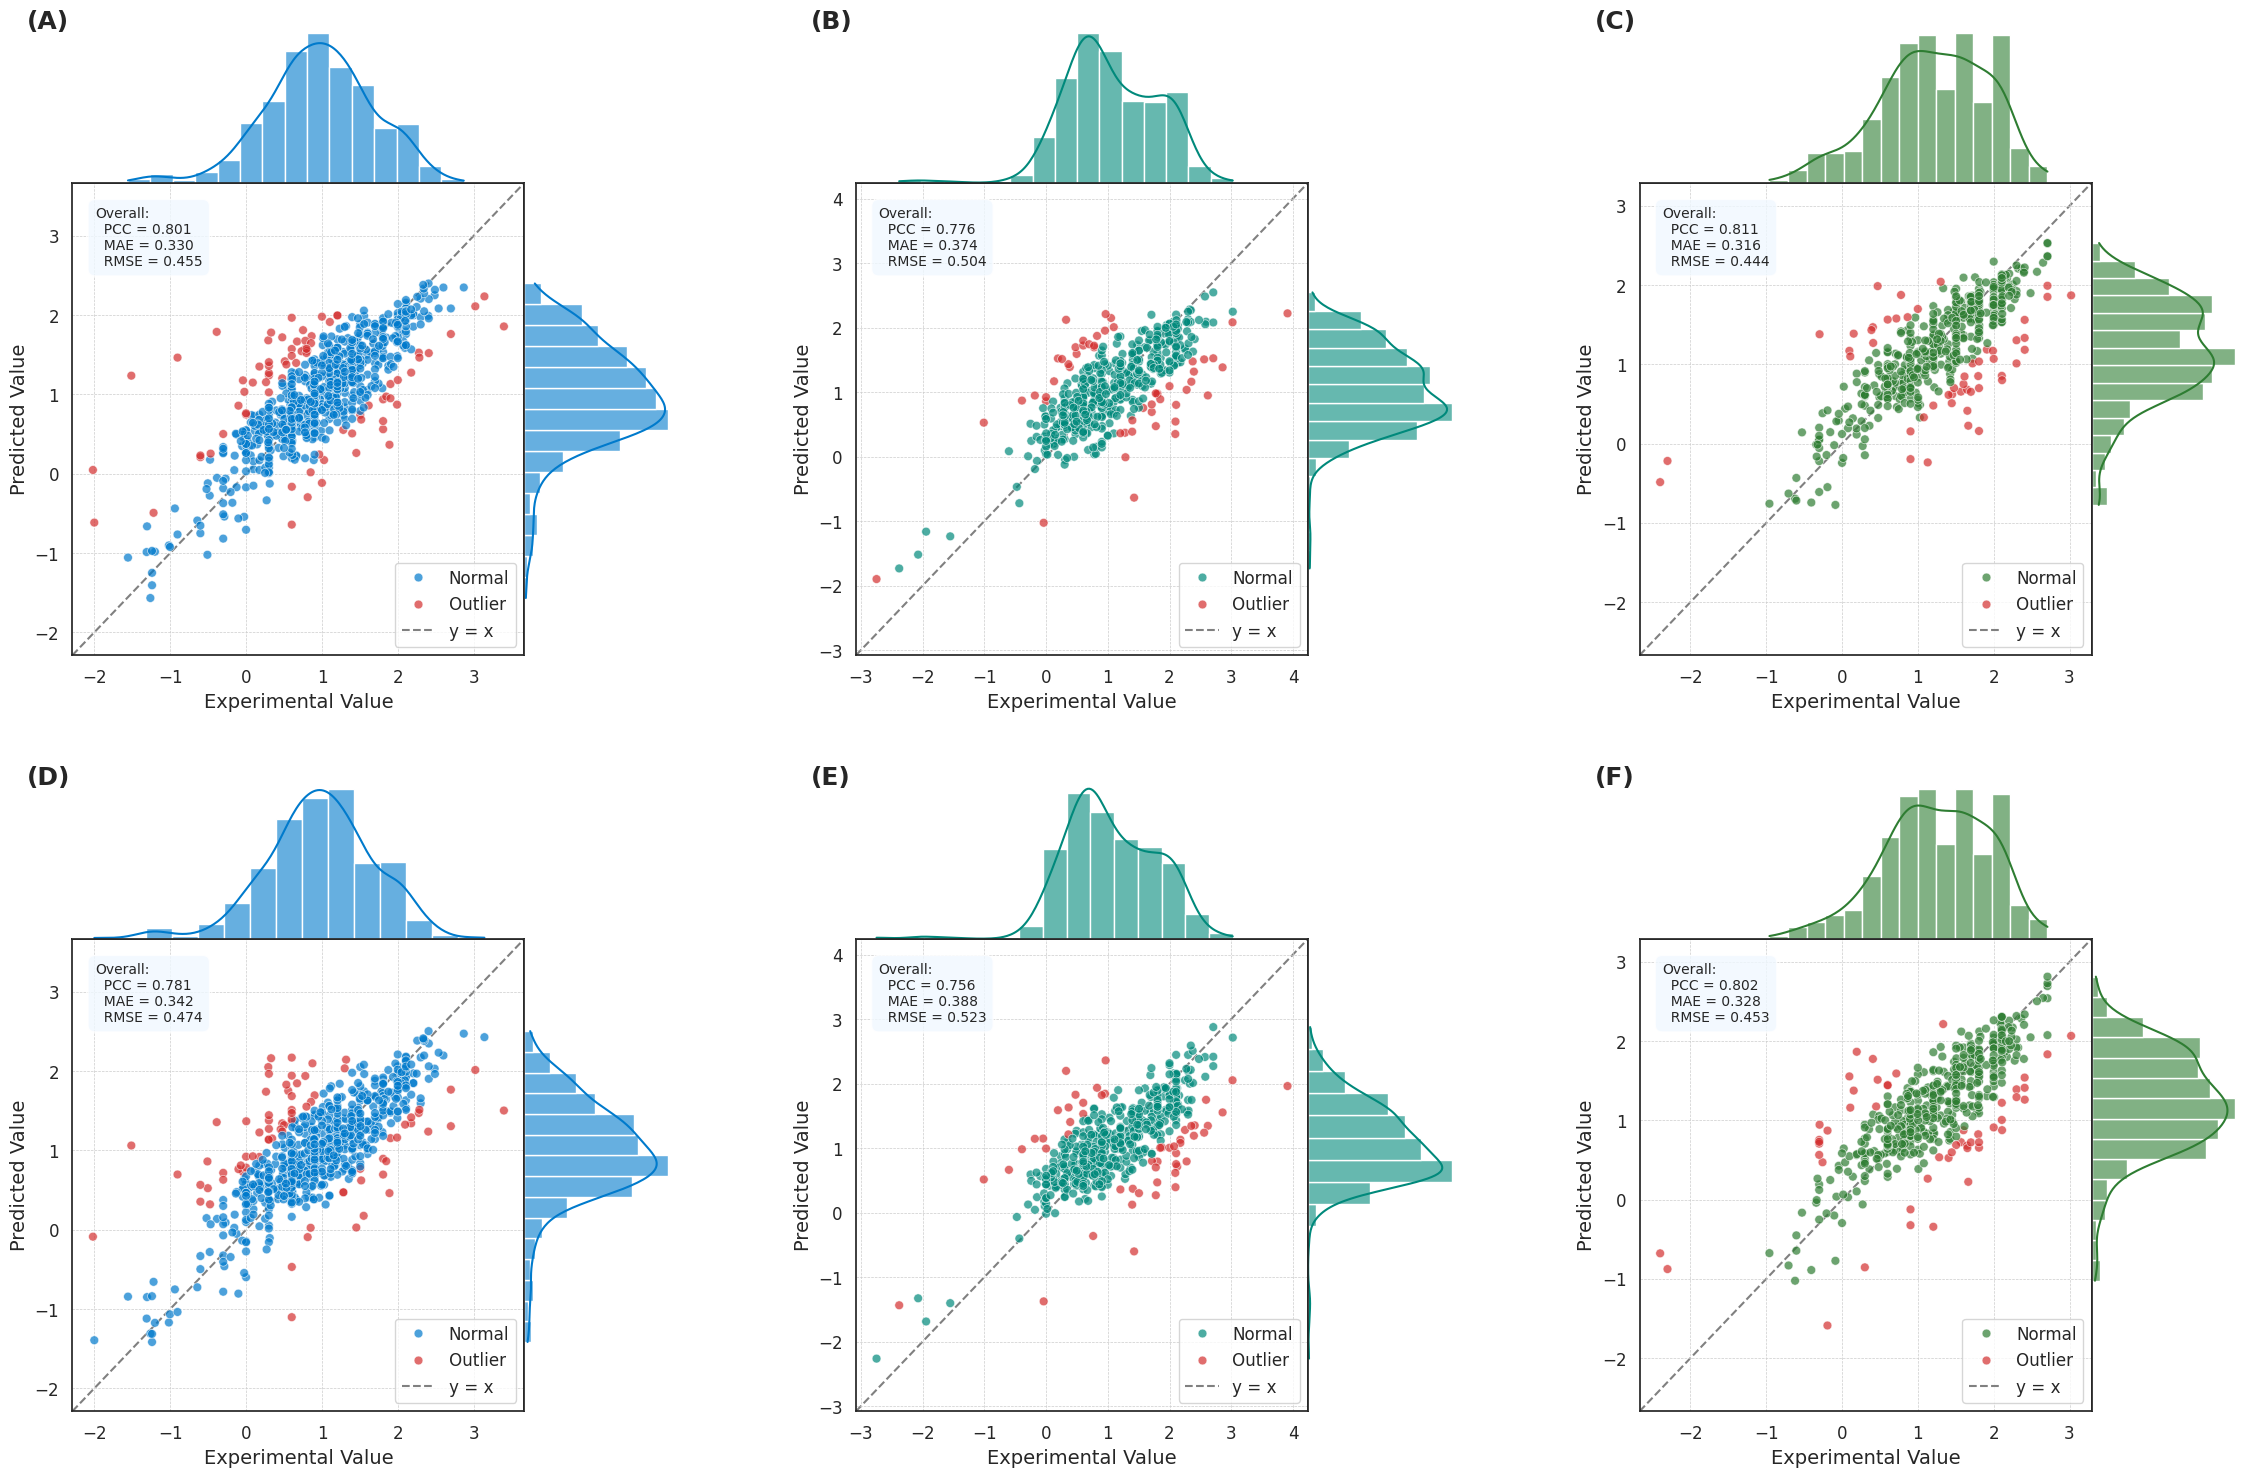

In [53]:
fig = plt.figure(figsize=(28, 18))
main_gs = fig.add_gridspec(2, 3, wspace=0.3)

# 在左侧子图 (gs[0, 0]) 绘制第一个模型的结果
plot_regression_subplot(
    fig=fig,
    spec=main_gs[0, 0],
    data=ec_df,
    x_col='true_value',
    y_col='predicted_value',
    title='Performance of Model 1 (Good)',
    xlabel='Experimental Value',
    ylabel='Predicted Value',
    palette={'Normal': '#007ACC', 'Outlier': '#D32F2F'},
    subplot_tag="(A)",
)

# 在右侧子图 (gs[0, 1]) 绘制第二个模型的结果
plot_regression_subplot(
    fig=fig,
    spec=main_gs[0, 1],
    data=sa_df,
    x_col='true_value',
    y_col='predicted_value',
    title='Performance of Model 2 (Poor)',
    xlabel='Experimental Value',
    ylabel='Predicted Value',
    palette={'Normal': '#00897B', 'Outlier': '#D32F2F'},
    subplot_tag="(B)",
)

# 在右侧子图 (gs[0, 2]) 绘制第三个模型的结果
plot_regression_subplot(
    fig=fig,
    spec=main_gs[0, 2],
    data=pa_df,
    x_col='true_value',
    y_col='predicted_value',
    title='Performance of Model 3 (Poor)',
    xlabel='Experimental Value',
    ylabel='Predicted Value',
    palette={'Normal': '#2E7D32', 'Outlier': '#D32F2F'},
    subplot_tag="(C)",
)

# 在第二行的子图中绘制基准模型的结果
plot_regression_subplot(
    fig=fig,
    spec=main_gs[1, 0],
    data=ec_base_df,
    x_col='true_MIC',
    y_col='Final_pred',
    title='Baseline Performance of EC',
    xlabel='Experimental Value',
    ylabel='Predicted Value',
    palette={'Normal': '#007ACC', 'Outlier': '#D32F2F'},
    subplot_tag="(D)",
)

plot_regression_subplot(
    fig=fig,
    spec=main_gs[1, 1],
    data=sa_base_df,
    x_col='true_MIC',
    y_col='Final_pred',
    title='Baseline Performance of SA',
    xlabel='Experimental Value',
    ylabel='Predicted Value',
    palette={'Normal': '#00897B', 'Outlier': '#D32F2F'},
    subplot_tag="(E)",
)

plot_regression_subplot(
    fig=fig,
    spec=main_gs[1, 2],
    data=pa_base_df,
    x_col='true_MIC',
    y_col='Final_pred',
    title='Baseline Performance of PA',
    xlabel='Experimental Value',
    ylabel='Predicted Value',
    palette={'Normal': '#2E7D32', 'Outlier': '#D32F2F'},
    subplot_tag="(F)",
)

plt.savefig("../figures/regression_performance.png", dpi=300, bbox_inches='tight')
plt.show()


In [76]:
def print_regression_performance(val_targets, val_preds, len_ec_val, len_sa_val):
    data_splits = {
        'EC': (val_targets[:len_ec_val], val_preds[:len_ec_val]),
        'SA': (val_targets[len_ec_val:len_ec_val + len_sa_val], val_preds[len_ec_val:len_ec_val + len_sa_val]),
        'PA': (val_targets[len_ec_val + len_sa_val:], val_preds[len_ec_val + len_sa_val:])
    }

    # Helper function to compute additional metrics
    def compute_additional_metrics(y_true, y_pred):
        if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
            pearson = float('nan')
        else:
            pearson = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return mae, pearson, r2

    for name, (targets, preds) in data_splits.items():
        if len(targets) > 1:
            mae, pearson, r2 = compute_additional_metrics(targets, preds)
            mse = mae ** 2
            print(f"[{name}] MSE: {mse:.4f}, MAE: {mae:.4f}, Pearson: {pearson:.4f}, R2: {r2:.4f}")


all_data = pd.read_csv("../save_model/ALL/best_predictions.csv")
print("=========================================================================================")
print("Overall Performance:")
print_regression_performance(all_data['true_value'].values, all_data['predicted_value'].values, len_ec_val, len_sa_val)

no_se_data = pd.read_csv("../save_model/no-se/best_predictions.csv")
print("=========================================================================================")
print("No-SE Performance:")
print_regression_performance(no_se_data['true_value'].values, no_se_data['predicted_value'].values, len_ec_val,
                             len_sa_val)

no_kan_data = pd.read_csv("../save_model/no-KAN/best_predictions.csv")
print("=========================================================================================")
print("No-KAN Performance:")
print_regression_performance(no_kan_data['true_value'].values, no_kan_data['predicted_value'].values, len_ec_val,
                             len_sa_val)

no_genome_feature_extraction_data = pd.read_csv("../save_model/no-genome_feature_extractor/best_predictions.csv")
print("=========================================================================================")
print("No-Genome Feature Extraction Performance:")
print_regression_performance(no_genome_feature_extraction_data['true_value'].values,
                             no_genome_feature_extraction_data['predicted_value'].values, len_ec_val, len_sa_val)

no_genome_feature_extraction_no_se_data = pd.read_csv(
    "../save_model/no-genome_feature_extractor & no-se/best_predictions.csv")
print("=========================================================================================")
print("No-Genome Feature Extraction & No-SE Performance:")
print_regression_performance(no_genome_feature_extraction_no_se_data['true_value'].values,
                             no_genome_feature_extraction_no_se_data['predicted_value'].values, len_ec_val, len_sa_val)

no_kan_no_se_data = pd.read_csv("../save_model/no-KAN & no-se/best_predictions.csv")
print("=========================================================================================")
print("No-KAN & No-SE Performance:")
print_regression_performance(no_kan_no_se_data['true_value'].values,
                             no_kan_no_se_data['predicted_value'].values, len_ec_val, len_sa_val)


Overall Performance:
[EC] MSE: 0.1087, MAE: 0.3296, Pearson: 0.8008, R2: 0.6334
[SA] MSE: 0.1396, MAE: 0.3737, Pearson: 0.7762, R2: 0.6013
[PA] MSE: 0.0998, MAE: 0.3160, Pearson: 0.8108, R2: 0.6526
No-SE Performance:
[EC] MSE: 0.1067, MAE: 0.3267, Pearson: 0.8036, R2: 0.6388
[SA] MSE: 0.1403, MAE: 0.3746, Pearson: 0.7735, R2: 0.5925
[PA] MSE: 0.1056, MAE: 0.3250, Pearson: 0.7987, R2: 0.6282
No-KAN Performance:
[EC] MSE: 0.1068, MAE: 0.3268, Pearson: 0.8010, R2: 0.6303
[SA] MSE: 0.1310, MAE: 0.3620, Pearson: 0.7869, R2: 0.6181
[PA] MSE: 0.1013, MAE: 0.3183, Pearson: 0.8039, R2: 0.6399
No-Genome Feature Extraction Performance:
[EC] MSE: 0.1487, MAE: 0.3856, Pearson: 0.7356, R2: 0.5384
[SA] MSE: 0.2295, MAE: 0.4791, Pearson: 0.6879, R2: 0.4025
[PA] MSE: 0.1841, MAE: 0.4291, Pearson: 0.7470, R2: 0.4342
No-Genome Feature Extraction & No-SE Performance:
[EC] MSE: 0.1469, MAE: 0.3832, Pearson: 0.7391, R2: 0.5434
[SA] MSE: 0.2359, MAE: 0.4857, Pearson: 0.6810, R2: 0.3880
[PA] MSE: 0.1911, MAE:

In [88]:
import pandas as pd
import numpy as np

# --- 1. 根据您提供的最新数据手动录入 ---
# 使用长格式数据结构，便于后续处理
long_format_data = [
    # Model, Bacteria, Metric, Value
    # Our Model (Overall)
    {'Model': 'Our Model', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1087},
    {'Model': 'Our Model', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.6334},
    {'Model': 'Our Model', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.8008},
    {'Model': 'Our Model', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.1396},
    {'Model': 'Our Model', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.6013},
    {'Model': 'Our Model', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.7762},
    {'Model': 'Our Model', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.0998},
    {'Model': 'Our Model', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.6526},
    {'Model': 'Our Model', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.8108},

    # w/o SE (No-SE)
    {'Model': 'w/o SE', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1067},
    {'Model': 'w/o SE', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.6388},
    {'Model': 'w/o SE', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.8036},
    {'Model': 'w/o SE', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.1403},
    {'Model': 'w/o SE', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.5925},
    {'Model': 'w/o SE', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.7735},
    {'Model': 'w/o SE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.1056},
    {'Model': 'w/o SE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.6282},
    {'Model': 'w/o SE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.7987},

    # w/o KAN (No-KAN)
    {'Model': 'w/o KAN', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1068},
    {'Model': 'w/o KAN', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.6303},
    {'Model': 'w/o KAN', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.8010},
    {'Model': 'w/o KAN', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.1310},
    {'Model': 'w/o KAN', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.6181},
    {'Model': 'w/o KAN', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.7869},
    {'Model': 'w/o KAN', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.1013},
    {'Model': 'w/o KAN', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.6399},
    {'Model': 'w/o KAN', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.8039},

    # w/o GFE (No-Genome)
    {'Model': 'w/o GFE', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1487},
    {'Model': 'w/o GFE', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.5384},
    {'Model': 'w/o GFE', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.7356},
    {'Model': 'w/o GFE', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.2295},
    {'Model': 'w/o GFE', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.4025},
    {'Model': 'w/o GFE', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.6879},
    {'Model': 'w/o GFE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.1841},
    {'Model': 'w/o GFE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.4342},
    {'Model': 'w/o GFE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.7470},

    # w/o GFE & SE
    {'Model': 'w/o GFE & SE', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1469},
    {'Model': 'w/o GFE & SE', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.5434},
    {'Model': 'w/o GFE & SE', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.7391},
    {'Model': 'w/o GFE & SE', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.2359},
    {'Model': 'w/o GFE & SE', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.3880},
    {'Model': 'w/o GFE & SE', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.6810},
    {'Model': 'w/o GFE & SE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.1911},
    {'Model': 'w/o GFE & SE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.4176},
    {'Model': 'w/o GFE & SE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.7436},

    # w/o KAN & SE
    {'Model': 'w/o KAN & SE', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1056},
    {'Model': 'w/o KAN & SE', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.6278},
    {'Model': 'w/o KAN & SE', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.7992},
    {'Model': 'w/o KAN & SE', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.1350},
    {'Model': 'w/o KAN & SE', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.6047},
    {'Model': 'w/o KAN & SE', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.7799},
    {'Model': 'w/o KAN & SE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.0991},
    {'Model': 'w/o KAN & SE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.6288},
    {'Model': 'w/o KAN & SE', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.7974},
]
# 为了包含RMSE，我们从MSE计算
for item in [d for d in long_format_data if d['Metrics'] == 'MSE']:
    long_format_data.append({
        'Model': item['Model'],
        'Bacteria': item['Bacteria'],
        'Metrics': 'RMSE',
        'Value': np.sqrt(item['Value'])
    })

# --- 2. 创建并重塑 DataFrame ---
df = pd.DataFrame(long_format_data)
summary_table = df.pivot_table(
    index=['Metrics', 'Bacteria'], columns='Model', values='Value'
)

# --- 3. 排序和美化 ---
metric_order = ['MSE', 'RMSE', 'R²', 'PCC']
bacteria_order = ['S. aureus', 'E. coli', 'P. aeruginosa']
model_order = ['Our Model', 'w/o SE', 'w/o KAN', 'w/o GFE', 'w/o GFE & SE', 'w/o KAN & SE']

final_index = pd.MultiIndex.from_product([metric_order, bacteria_order], names=['Metrics', 'Bacteria'])
summary_table = summary_table.reindex(index=final_index, columns=model_order)
summary_table.columns.name = "Models"


def highlight_best(row):
    metric = row.name[0]
    higher_is_better = ['R²', 'PCC']
    valid_row = row.dropna()
    if valid_row.empty: return ['' for _ in row]
    best_value = valid_row.max() if metric in higher_is_better else valid_row.min()
    return ['font-weight: bold; color: #D32F2F;' if v == best_value else '' for v in row]


styled_table = summary_table.style \
    .format("{:.3f}", na_rep="-") \
    .apply(highlight_best, axis=1) \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([
    {'selector': 'th, td', 'props': [('border', '1px solid #cccccc')]},
    {'selector': 'th', 'props': [
        ('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('text-align', 'center')
    ]},
    {'selector': 'th.row_heading', 'props': [('text-align', 'left'), ('padding-left', '10px')]},
    {'selector': 'th.col_heading', 'props': [('font-size', '1.1em')]},
])

# 显示表格
display(styled_table)
# Save the styled table to an HTML file
styled_table.to_html("../figures/regression_summary_table.html",
                     table_attributes='style="width: 100%; border-collapse: collapse;"',
                     classes='dataframe')

In [90]:
def print_regression_performance(val_targets, val_preds, len_ec_val, len_sa_val):
    data_splits = {
        'EC': (val_targets[:len_ec_val], val_preds[:len_ec_val]),
        'SA': (val_targets[len_ec_val:len_ec_val + len_sa_val], val_preds[len_ec_val:len_ec_val + len_sa_val]),
        'PA': (val_targets[len_ec_val + len_sa_val:], val_preds[len_ec_val + len_sa_val:])
    }

    # Helper function to compute additional metrics
    def compute_additional_metrics(y_true, y_pred):
        if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
            pearson = float('nan')
        else:
            pearson = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return mae, pearson, r2

    for name, (targets, preds) in data_splits.items():
        if len(targets) > 1:
            mae, pearson, r2 = compute_additional_metrics(targets, preds)
            mse = mae ** 2
            print(f"[{name}] MSE: {mse:.4f}, MAE: {mae:.4f}, Pearson: {pearson:.4f}, R2: {r2:.4f}")


T5_data = pd.read_csv("../save_model/ALL/best_predictions.csv")
print("=========================================================================================")
print("T5-UniRef50 Performance:")
print_regression_performance(all_data['true_value'].values, all_data['predicted_value'].values, len_ec_val, len_sa_val)

ESM2_8M_data = pd.read_csv("../save_model/ESM2-8M/best_predictions.csv")
print("=========================================================================================")
print("ESM-8M Performance:")
print_regression_performance(ESM2_8M_data['true_value'].values, ESM2_8M_data['predicted_value'].values, len_ec_val,
                             len_sa_val)

ESM2_35M_data = pd.read_csv("../save_model/ESM2-35M/best_predictions.csv")
print("=========================================================================================")
print("ESM-35M Performance:")
print_regression_performance(ESM2_35M_data['true_value'].values, ESM2_35M_data['predicted_value'].values, len_ec_val,
                             len_sa_val)

ESM2_150M_data = pd.read_csv("../save_model/ESM2-150M/best_predictions.csv")
print("=========================================================================================")
print("ESM-150M Performance:")
print_regression_performance(ESM2_150M_data['true_value'].values, ESM2_150M_data['predicted_value'].values, len_ec_val,
                             len_sa_val)

ESM2_650M_data = pd.read_csv("../save_model/ESM2-650M/best_predictions.csv")
print("=========================================================================================")
print("ESM-650M Performance:")
print_regression_performance(ESM2_650M_data['true_value'].values, ESM2_650M_data['predicted_value'].values, len_ec_val,
                             len_sa_val)


T5-UniRef50 Performance:
[EC] MSE: 0.1113, MAE: 0.3336, Pearson: 0.8256, R2: 0.6693
[SA] MSE: 0.1774, MAE: 0.4212, Pearson: 0.6507, R2: 0.3482
[PA] MSE: 0.1118, MAE: 0.3343, Pearson: 0.8044, R2: 0.6461
ESM-8M Performance:
[EC] MSE: 0.1007, MAE: 0.3174, Pearson: 0.8173, R2: 0.6548
[SA] MSE: 0.1802, MAE: 0.4245, Pearson: 0.6327, R2: 0.2600
[PA] MSE: 0.1339, MAE: 0.3660, Pearson: 0.7591, R2: 0.5593
ESM-35M Performance:
[EC] MSE: 0.1442, MAE: 0.3797, Pearson: 0.7601, R2: 0.5444
[SA] MSE: 0.1553, MAE: 0.3941, Pearson: 0.6786, R2: 0.3865
[PA] MSE: 0.1267, MAE: 0.3559, Pearson: 0.7747, R2: 0.5879
ESM-150M Performance:
[EC] MSE: 0.1368, MAE: 0.3698, Pearson: 0.7896, R2: 0.5857
[SA] MSE: 0.1936, MAE: 0.4400, Pearson: 0.6400, R2: 0.2643
[PA] MSE: 0.1417, MAE: 0.3764, Pearson: 0.7632, R2: 0.5628
ESM-650M Performance:
[EC] MSE: 0.1221, MAE: 0.3494, Pearson: 0.7964, R2: 0.6095
[SA] MSE: 0.1711, MAE: 0.4136, Pearson: 0.6730, R2: 0.3386
[PA] MSE: 0.1181, MAE: 0.3436, Pearson: 0.7892, R2: 0.6150


In [91]:
import pandas as pd
import numpy as np

# --- 1. 根据您提供的最新pLM实验数据录入 ---
long_format_data = [
    # Model, Bacteria, Metric, Value
    # T5-UniRef50
    {'Model': 'T5-UniRef50', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1113},
    {'Model': 'T5-UniRef50', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.6693},
    {'Model': 'T5-UniRef50', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.8256},
    {'Model': 'T5-UniRef50', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.1774},
    {'Model': 'T5-UniRef50', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.3482},
    {'Model': 'T5-UniRef50', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.6507},
    {'Model': 'T5-UniRef50', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.1118},
    {'Model': 'T5-UniRef50', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.6461},
    {'Model': 'T5-UniRef50', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.8044},

    # ESM-8M
    {'Model': 'ESM-8M', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1007},
    {'Model': 'ESM-8M', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.6548},
    {'Model': 'ESM-8M', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.8173},
    {'Model': 'ESM-8M', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.1802},
    {'Model': 'ESM-8M', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.2600},
    {'Model': 'ESM-8M', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.6327},
    {'Model': 'ESM-8M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.1339},
    {'Model': 'ESM-8M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.5593},
    {'Model': 'ESM-8M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.7591},

    # ESM-35M
    {'Model': 'ESM-35M', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1442},
    {'Model': 'ESM-35M', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.5444},
    {'Model': 'ESM-35M', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.7601},
    {'Model': 'ESM-35M', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.1553},
    {'Model': 'ESM-35M', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.3865},
    {'Model': 'ESM-35M', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.6786},
    {'Model': 'ESM-35M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.1267},
    {'Model': 'ESM-35M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.5879},
    {'Model': 'ESM-35M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.7747},

    # ESM-150M
    {'Model': 'ESM-150M', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1368},
    {'Model': 'ESM-150M', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.5857},
    {'Model': 'ESM-150M', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.7896},
    {'Model': 'ESM-150M', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.1936},
    {'Model': 'ESM-150M', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.2643},
    {'Model': 'ESM-150M', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.6400},
    {'Model': 'ESM-150M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.1417},
    {'Model': 'ESM-150M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.5628},
    {'Model': 'ESM-150M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.7632},

    # ESM-650M
    {'Model': 'ESM-650M', 'Bacteria': 'E. coli', 'Metrics': 'MSE', 'Value': 0.1221},
    {'Model': 'ESM-650M', 'Bacteria': 'E. coli', 'Metrics': 'R²', 'Value': 0.6095},
    {'Model': 'ESM-650M', 'Bacteria': 'E. coli', 'Metrics': 'PCC', 'Value': 0.7964},
    {'Model': 'ESM-650M', 'Bacteria': 'S. aureus', 'Metrics': 'MSE', 'Value': 0.1711},
    {'Model': 'ESM-650M', 'Bacteria': 'S. aureus', 'Metrics': 'R²', 'Value': 0.3386},
    {'Model': 'ESM-650M', 'Bacteria': 'S. aureus', 'Metrics': 'PCC', 'Value': 0.6730},
    {'Model': 'ESM-650M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'MSE', 'Value': 0.1181},
    {'Model': 'ESM-650M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'R²', 'Value': 0.6150},
    {'Model': 'ESM-650M', 'Bacteria': 'P. aeruginosa', 'Metrics': 'PCC', 'Value': 0.7892},
]

# 计算RMSE
for item in [d for d in long_format_data if d['Metrics'] == 'MSE']:
    long_format_data.append({
        'Model': item['Model'], 'Bacteria': item['Bacteria'],
        'Metrics': 'RMSE', 'Value': np.sqrt(item['Value'])
    })

# --- 2. 创建并重塑 DataFrame ---
df = pd.DataFrame(long_format_data)
summary_table = df.pivot_table(index=['Metrics', 'Bacteria'], columns='Model', values='Value')

# --- 3. 排序和美化 ---
metric_order = ['MSE', 'RMSE', 'R²', 'PCC']
bacteria_order = ['S. aureus', 'E. coli', 'P. aeruginosa']
model_order = ['T5-UniRef50', 'ESM-8M', 'ESM-35M', 'ESM-150M', 'ESM-650M']

final_index = pd.MultiIndex.from_product([metric_order, bacteria_order], names=['Metrics', 'Bacteria'])
summary_table = summary_table.reindex(index=final_index, columns=model_order)
summary_table.columns.name = "Pre-trained Language Models"


def highlight_best(row):
    metric = row.name[0]
    higher_is_better = ['R²', 'PCC']
    valid_row = row.dropna()
    if valid_row.empty: return ['' for _ in row]
    best_value = valid_row.max() if metric in higher_is_better else valid_row.min()
    return ['font-weight: bold; color: #D32F2F;' if v == best_value else '' for v in row]


styled_table = summary_table.style \
    .format("{:.3f}", na_rep="-") \
    .apply(highlight_best, axis=1) \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([
    {'selector': 'th, td', 'props': [('border', '1px solid #cccccc')]},
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th.row_heading', 'props': [('text-align', 'left'), ('padding-left', '10px')]},
    {'selector': 'th.col_heading', 'props': [('font-size', '1.1em')]},
])

# 显示表格
display(styled_table)